In [1]:
import pandas as pd
import geopandas as gpd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Load data and combine
1. Load Aleph wind farms
2. Load MapStand data
3. Combine
4. Save

## Load Aleph Data
need to add content of ftm  env to current environment for this to work


In [2]:
host = "https://data.ftm.nl/"
api_key = "Ai9e2w9tc95-JsvrbGQSX4moHgriPD2nm3lo9TogC_k"
foreign_id = "ce5001727ffb4d3cb42cc8c594395c22"
fn = r"C:\Users\n649505\code\ftm_north_sea_data\north_sea_wind_assets.csv"
#os.system("alephclient --host %s --api-key %s stream-entities -f %s -s Asset > %s" % (host, api_key, foreign_id, fn))
print("alephclient --host %s --api-key %s stream-entities -f %s -s Asset > %s" % (host, api_key, foreign_id, fn))

alephclient --host https://data.ftm.nl/ --api-key Ai9e2w9tc95-JsvrbGQSX4moHgriPD2nm3lo9TogC_k stream-entities -f ce5001727ffb4d3cb42cc8c594395c22 -s Asset > C:\Users\n649505\code\ftm_north_sea_data\north_sea_wind_assets.csv


Saved format from Aleph is funky. Open in MS Excel and save as csv

In [3]:
data_fn = "../../../ftm_north_sea_data/north_sea_wind_assets.csv"

raw_df = pd.read_csv(data_fn,header=None, encoding="utf-8")

asset_df = pd.json_normalize([json.loads(line) for line in raw_df[0].tolist() if json.loads(line)["schema"]=="Asset"])

asset_df.rename(columns={"properties.name":"name", "properties.notes": "status", "properties.country": "country", "properties.description": "mps_id", 
                         "properties.amountEur": "value_eur", "properties.publisherUrl": "source", "properties.amount": "installed_capacity_mw",
                         "id": "aleph_id"}, inplace=True)

cols = ["name", "status", "installed_capacity_mw", "country", "mps_id", "value_eur", "source"]
for col in cols:
    asset_df[col] = asset_df[col].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)

print("Aleph dataset has %d windfarms" % asset_df.shape[0])
asset_df.head()

Aleph dataset has 418 windfarms


,schema,aleph_id,name,status,country,mps_id,source,properties.alephUrl,value_eur,installed_capacity_mw,properties.alias,properties.summary,properties.proof,properties.modifiedAt
0,Asset,2bdfd745-078a-4f43-a48a-2369bf075b65.94840fadf...,MARRAMWIND,EXCLUSIVE_DEVELOPMENT_RIGHTS,gb,d9269c72-f7e4-4a56-ae30-509641e78100,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/2bdfd745-0...,NaN,NaN,NaN,NaN,NaN,NaN
1,Asset,2cd5ec33-c4b3-4a36-b3fd-b10bf9524a02.cfc730eeb...,GREATER GABBARD,OPERATIONAL,gb,45ed8574-61fc-4eeb-b1ec-04daa8b4d961,https://www.eib.org/en/projects/pipelines/all/...,[https://data.ftm.nl/api/2/entities/2cd5ec33-c...,1998000000,NaN,NaN,NaN,NaN,NaN
2,Asset,31e7990f-9393-4822-945b-46deee47d3ad.6d173b591...,TEN NOORDEN VAN DE WADDENEILANDEN,PROJECT_ANNOUNCED,nl,2a0d18b9-a090-462b-80fd-f8a198cd1f55,"https://www.mapstand.com/, https://www.rvo.nl/...",[https://data.ftm.nl/api/2/entities/31e7990f-9...,NaN,700 MW,NaN,NaN,NaN,NaN
3,Asset,2888d47b-9ae3-4d1a-aa61-38d387e53553.ef7aff3f9...,NOMADIC OFFSHORE WIND FARM,PROJECT_ANNOUNCED,gb,4877e794-b04a-44fe-a349-eb9a6f31de4c,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/2888d47b-9...,NaN,NaN,NaN,NaN,NaN,NaN
4,Asset,2f81af81-0bf9-4783-b743-b1a6b7ad57fc.1b99de797...,GATROBEN,EARLY_PLANNING,gb,d448338a-64de-426c-9a8c-1d552cfc3758,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/2f81af81-0...,NaN,NaN,[DOGGERBANK 4],NaN,NaN,NaN


In [4]:
# load file Dimitri made with some missing capacity
df_d = gpd.read_file("../../../ftm_north_sea_data/analysis_v1.geojson")

df_d = df_d.set_index("id")

## Load MapStand

In [5]:
token_wfs = "0f5ed330-90f4-4f28-9214-5d981f3db642"
token_wms = "74d99a64-fdf4-4641-a390-c909665414ff"

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:powerplant_windfarm_installed&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_installed = gpd.GeoDataFrame.from_features(data, crs=4326)

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:powerplant_windfarm_planned&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_planned = gpd.GeoDataFrame.from_features(data, crs=4326)

url = "https://hub.mapstand.com/gs/ows?service=WFS&VERSION=1.0.0&request=GetFeature&typename=mps:wind_development_zone&outputFormat=json&srsName=EPSG:4326&apikey=%s" % token_wms
response = requests.get(url)
data = response.json()["features"]
gdf_wdz = gpd.GeoDataFrame.from_features(data, crs=4326)

#concatenate
rdf = gpd.GeoDataFrame(pd.concat((gdf_planned, gdf_installed, gdf_wdz), ignore_index=True), crs=gdf_planned.crs)

## Combine datasets
1. Use capacity from Aleph if it exists (*TO DO and capacity/year/amount from analysis.geojson TO DO*)
2. Make a simplified status column
3. Remove Norwegian competing tenders
4. Subselect columns
4. Save to geojson (for streamlit app) and excel 

In [6]:
cols_to_keep = ["mps_uuid", "capacity_mw", "geometry", "installation_year", 
                "mps_est_elevation_min_m", "mps_est_elevation_max_m", "coast_distance",
                "mps_est_shore_status", "windfarm_type", "number_generators",
                "mps_est_area_sqkm"]
merged = pd.merge(asset_df, rdf[cols_to_keep],
          left_on = "mps_id", right_on="mps_uuid", how="left").set_index("aleph_id")

# update capacities with manually entered ones
merged["capacity"] = pd.to_numeric(merged.installed_capacity_mw.apply(lambda x: x.strip(" MW") if isinstance(x, str) else x)).fillna(merged.capacity_mw)

In [7]:
# correct installation year
df_d.loc[df_d.name_aleph=="BLYTH II & III","installation_year"] = 2025
df_d.loc[df_d.name_aleph=="HYWIND TAMPEN","installation_year"] = 2023
df_d.loc[df_d.name_aleph=="FLAGSHIP","installation_year"] = 2024
df_d.loc[df_d.name_aleph=="N-14.1","installation_year"] = 2033
df_d.loc[df_d.name_aleph.isin(("UTSIRA NORD", "SORLIGE NORDSJO II")),"installation_year"] = 2030

In [8]:
# merge dimitri's data with aleph + mapstand
merged["year_d"] = df_d["installation_year"]
merged["cap_d"] = df_d["capacity_mw"]
merged["amount_d"] = df_d["amountEur"]

# fill in missing values
merged.capacity = merged.capacity.fillna(merged["cap_d"])
merged.installation_year = merged.installation_year.fillna(merged["year_d"])
merged.value_eur = merged.capacity.fillna(merged["amount_d"])

In [9]:
# status dictionary
st_dict = {'OPERATIONAL': "EXISTING", 
 'EXCLUSIVE_DEVELOPMENT_RIGHTS': "EARLY_STAGE_PLANS",
 'UNDER_CONSTRUCTION': "EXISTING", 
 'PROJECT_ANNOUNCED': "POTENTIAL_PLANS", 
 'EARLY_PLANNING': "EARLY_STAGE_PLANS",
'APPLICATION_SUBMITTED': "LATE_STAGE_PLANS", 
'CONSENT_AUTHORISED': "LATE_STAGE_PLANS", 
'EXTENSION_REQUESTED': "LATE_STAGE_PLANS", 
'CANCELLED': "", 
'ONSHORE - OPERATIONAL': "",
'DECOMMISSIONED': "", 
'AREA_PROPOSED': "POTENTIAL_PLANS",
"AREA_UNDER_STATE_INVESTIGATION": "POTENTIAL_PLANS",
"COMPETING_PROPOSALS": "EARLY_STAGE_PLANS",
"TENDER_PENDING": "EARLY_STAGE_PLANS",
"PLANNING_PERMISSION_EXPIRED": ""}
merged["simple_status"] = merged.status.replace(st_dict)

In [14]:
cols_to_keep = ['name', 'status','simple_status', 'country', 'value_eur', 
        'capacity', 'installation_year', "coast_distance", "number_generators", 'mps_est_elevation_min_m',
       'mps_est_shore_status', 'windfarm_type', 'mps_est_area_sqkm',
       'source']

merged[cols_to_keep].to_excel("../../../ftm_north_sea_data/north_sea_windparks_v4.xlsx")

### Clean Norway's data

In [11]:
# remove Norway's announced projects as they are redundant with the area proposed
no_redundant_plans = ["a89d6541-e184-49bb-9523-074760f8e205", # Skjoldblad 1
                      "a71d7529-9523-4339-8ecb-1d9c38304a5d", #Vestavindar
                      "b1691a7e-c118-4202-8743-220db5f5964a", # Sonnavindar 1
                      "11808e1a-00eb-4ff3-a243-0e2fbae33948", # not in data anymore
                      "0cea04d5-5e6b-444c-967d-3eaf0141c8e9", # Skjoldblad 2
                      "1a142c99-525d-4a53-a3a9-229717c372b2"] # Sonnavindar 2

merged_no = merged.drop(merged[merged.mps_id.isin(no_redundant_plans)].index)

# alternatively drop all the plans with status competing proposals
merged[(merged.country=="no") & (merged.status=="COMPETING_PROPOSALS")]

,schema,name,status,country,mps_id,source,properties.alephUrl,value_eur,installed_capacity_mw,properties.alias,...,coast_distance,mps_est_shore_status,windfarm_type,number_generators,mps_est_area_sqkm,capacity,year_d,cap_d,amount_d,simple_status
aleph_id,,,,,,,,,,,,,,,,,,,,,
a33801b3-8d21-48be-8803-13daa96089fa.c083dd875bf7b18b29db7f74e98bd3195ec725ac,Asset,SOUTHERN NORTH SEA II (PHASE 2) - SKJOLDBLAD,COMPETING_PROPOSALS,no,0cea04d5-5e6b-444c-967d-3eaf0141c8e9,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/a33801b3-8...,1500.0,NaN,NaN,...,NaN,OFFSHORE,OFFSHORE_FIXED,NaN,1264.613853,1500.0,2030.0,1500.0,NaN,EARLY_STAGE_PLANS
828ab8ce-7825-4cdf-9ff6-f16a66fc66c8.02e1996aaed40610ed6537ef1f42e6c5dec68583,Asset,VESTAVINDAR,COMPETING_PROPOSALS,no,a71d7529-9523-4339-8ecb-1d9c38304a5d,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/828ab8ce-7...,1500.0,NaN,NaN,...,NaN,OFFSHORE,OFFSHORE_FLOATING,NaN,1001.768390,1500.0,2026.0,1500.0,NaN,EARLY_STAGE_PLANS
f4c64c05-af5a-4d3e-8b36-ab2791e25671.3114e066ac5c899d04f1a256a58f31872fb630e4,Asset,SONNAVINDAR PHASE 2,COMPETING_PROPOSALS,no,1a142c99-525d-4a53-a3a9-229717c372b2,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/f4c64c05-a...,1500.0,NaN,NaN,...,NaN,OFFSHORE,OFFSHORE_MIXED,NaN,1264.613853,1500.0,2029.0,1500.0,NaN,EARLY_STAGE_PLANS
f682b067-1902-4cad-8696-7a8fc38a0ad4.83b0194d227b46af3b424d3b20d904401a214f40,Asset,SONNAVINDAR PHASE 1,COMPETING_PROPOSALS,no,b1691a7e-c118-4202-8743-220db5f5964a,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/f682b067-1...,1500.0,NaN,NaN,...,NaN,OFFSHORE,OFFSHORE_MIXED,NaN,1300.877540,1500.0,2026.0,1500.0,NaN,EARLY_STAGE_PLANS
12e08f7a-fa9c-4af7-9d1f-71e53866bb1e.eacb689005d0342f146f7cd8b672cc1735333e95,Asset,SOUTHERN NORTH SEA II (PHASE 1) - SKJOLDBLAD,COMPETING_PROPOSALS,no,a89d6541-e184-49bb-9523-074760f8e205,https://www.mapstand.com/,[https://data.ftm.nl/api/2/entities/12e08f7a-f...,1500.0,NaN,NaN,...,NaN,OFFSHORE,OFFSHORE_FIXED,NaN,1300.877540,1500.0,2030.0,1500.0,NaN,EARLY_STAGE_PLANS


### Save data to geojson

In [12]:
cols_to_keep = ['name', 'status', 'country', 'value_eur',
       'mps_id', 'source', 'installed_capacity_mw',
        'mps_uuid', 'capacity_mw', "number_generators",
       'geometry', 'installation_year', 'mps_est_elevation_min_m', "mps_est_elevation_max_m",
       'mps_est_shore_status', 'windfarm_type', 'mps_est_area_sqkm',
       'capacity', 'simple_status']
df = gpd.GeoDataFrame(merged_no[cols_to_keep], geometry=merged_no.geometry, crs="EPSG:4326")
df.to_file("../../../ftm_north_sea_data/wind_farms_%s.geojson" % datetime.datetime.now().strftime('%Y%m%d'), driver="GeoJSON")

In [14]:
df[df.simple_status=="EXISTING"].to_file("../../../ftm_north_sea_data/existing_wind_farms.geojson", driver="GeoJSON")

# Make some plots

c:\Users\n649505\AppData\Local\miniconda3\envs\ftm\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\n649505\AppData\Local\miniconda3\envs\ftm\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\n649505\AppData\Local\miniconda3\envs\ftm\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\n649505\AppData\Local\miniconda3\envs\ftm\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

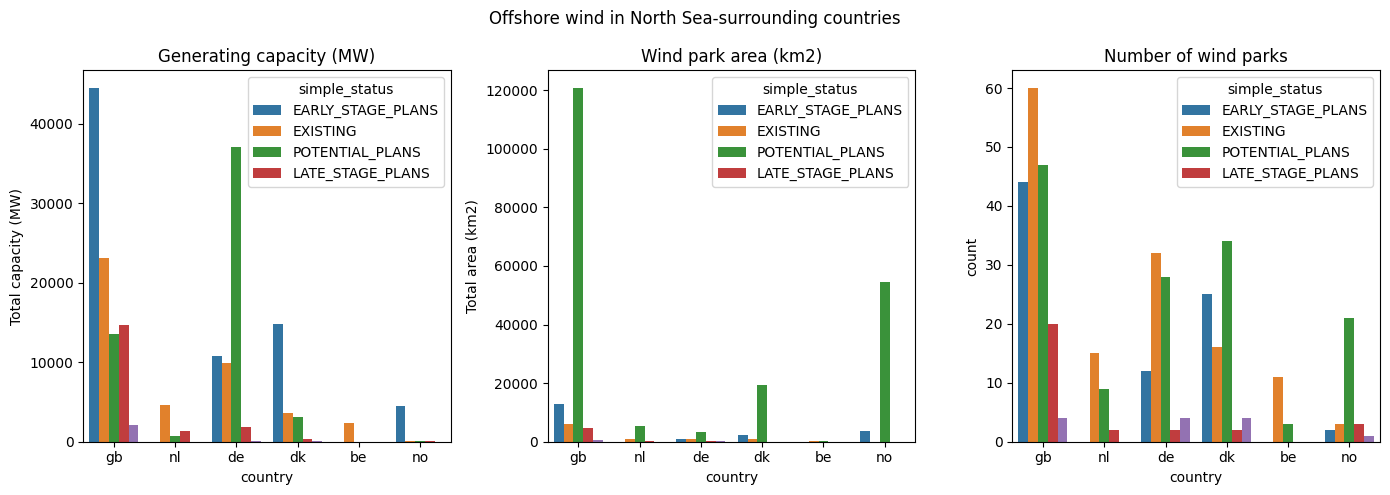

In [30]:
f, axs = plt.subplots(1,3,figsize=(14,5))
sns.barplot(merged_no, x="country", y="capacity", hue="simple_status", estimator="sum", errorbar=None, ax=axs[0])
axs[0].set_title("Generating capacity (MW)")
axs[0].set_ylabel("Total capacity (MW)")
sns.barplot(merged_no, x="country", y="mps_est_area_sqkm", hue="simple_status", estimator="sum", errorbar=None, ax=axs[1])
axs[1].set_title("Wind park area (km2)")
axs[1].set_ylabel("Total area (km2)")
sns.countplot(merged_no, x="country", hue="simple_status", ax=axs[2])
axs[2].set_title("Number of wind parks")
f.suptitle("Offshore wind in North Sea-surrounding countries")
f.tight_layout()

The built-in plotly.js styles objects are: carto-darkmatter, carto-positron, open-street-map, stamen-terrain, stamen-toner, stamen-watercolor, white-bg The built-in Mapbox styles are: basic, streets, outdoors, light, dark, satellite, satellite-streets Mapbox style URLs are of the form: mapbox://mapbox.mapbox-\<name\>-\<version\>


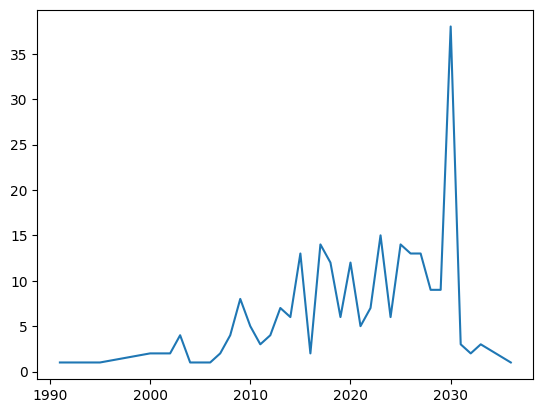

In [26]:
plt.plot(df.groupby("installation_year").name.count().index,df.groupby("installation_year").name.count().tolist())

In [33]:
depth = df[["country", "mps_est_elevation_min_m", "mps_est_elevation_max_m"]]
depth = pd.melt(depth, value_vars=["mps_est_elevation_min_m", "mps_est_elevation_max_m"], id_vars=["country"])
depth.replace({"mps_est_elevation_min_m": "min", "mps_est_elevation_max_m": "max"})

,country,variable,value
0,be,min,-34.0
1,be,min,-24.0
2,nl,min,-23.0
3,nl,min,-19.0
4,be,min,-33.0
...,...,...,...
635,dk,max,-2.0
636,gb,max,-9.0
637,de,max,-38.0
638,de,max,-25.0
